In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

코랩 사용하시는 분들은 아래의 코드를 실행해주세요!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.getcwd()

'/content'

코랩 사용시 본인 구글 드라이브 경로는  
/content/drive/MyDrive/...  
입니다.

In [4]:
path = '/content/drive/MyDrive/Regular Session Homework/Supervised Learning' # 과제 데이터셋이 저장된 경로를 더 작성해주세요
os.chdir(path)

In [5]:
os.getcwd()

'/content/drive/MyDrive/Regular Session Homework/Supervised Learning'

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [30]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [31]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [32]:
def load_data():
    data = pd.read_csv('train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [33]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [34]:
# 데이터 셋을 둘러보는 코드 작성하시고, 왜 좋은지 한번 둘러보세요!
train_x.corr()

,Temp,Wind,Moisture,Precipitation,Sun
Temp,1.000000,0.510935,-0.628642,-0.173210,0.783829
Wind,0.510935,1.000000,-0.478825,0.028617,0.544720
Moisture,-0.628642,-0.478825,1.000000,0.152529,-0.699047
Precipitation,-0.173210,0.028617,0.152529,1.000000,-0.123846
Sun,0.783829,0.544720,-0.699047,-0.123846,1.000000


변수들만을 가지고 상관계수행렬을 살펴보았을 때, Temperature와 Sun, Wind 간의 상관계수는 양의 관계이고, Moisture와 Precipitation은 타 변수들과 음의 관계가 있었다. 이는 우리의 직관과도 맞는 상관계수이다.

우리의 목적인 전력사용량 예측을 하기 위해서는 train_y 변수도 포함해서 상관계수행렬을 구해보는 것이 좋을 것이라 판단하여 밑에 코드를 진행하였다.

In [35]:
analysis1 = pd.concat([train_x,train_y], axis = 1)
analysis1.corr()

,Temp,Wind,Moisture,Precipitation,Sun,Wh
Temp,1.000000,0.510935,-0.628642,-0.173210,0.783829,0.803301
Wind,0.510935,1.000000,-0.478825,0.028617,0.544720,0.349288
Moisture,-0.628642,-0.478825,1.000000,0.152529,-0.699047,-0.095042
Precipitation,-0.173210,0.028617,0.152529,1.000000,-0.123846,-0.090389
Sun,0.783829,0.544720,-0.699047,-0.123846,1.000000,0.458348
Wh,0.803301,0.349288,-0.095042,-0.090389,0.458348,1.000000


정답은 없습니다! 

다만 최종 선택한 변수(들)이 왜 선택받았는지 간단히 알려주세요.<br>
답변 : Temperature. 우리가 예측하고자 하는 전력사용량과의 상관계수 중 가장 높은 양의 상관관계를 보이는 변수는 Temp였다. 이외, Sun 변수의 경우, temp 변수와 상관관계가 높기 때문에 두 변수를 모두 사용한 선형회귀는 overfit이 되거나 무의미할 수 있다고 판단하였다. 선형 회귀식은 가장 적은 변수로 높은 설명력을 보이면 최선이라고 생각해서 가장 최소한의 변수를 선택하고자 하였다.

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [36]:
#MinMaxScaler 활용 시도
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [37]:
train_x = train_x['Temp']
# train_y 그대로 output 데이터로 사용

train_x = train_x[:, np.newaxis]
train_x1 = scaler.fit_transform(train_x)
train_x1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


array([[0.20895522],
       [0.21641791],
       [0.20149254],
       [0.17164179],
       [0.1641791 ],
       [0.15671642],
       [0.14179104],
       [0.15671642],
       [0.2238806 ],
       [0.3358209 ],
       [0.42537313],
       [0.54477612],
       [0.61940299],
       [0.61940299],
       [0.65671642],
       [0.67164179],
       [0.71641791],
       [0.65671642],
       [0.58955224],
       [0.48507463],
       [0.37313433],
       [0.28358209],
       [0.23134328],
       [0.17910448],
       [0.13432836],
       [0.10447761],
       [0.08208955],
       [0.06716418],
       [0.05223881],
       [0.        ],
       [0.01492537],
       [0.05223881],
       [0.08955224],
       [0.15671642],
       [0.18656716],
       [0.20149254],
       [0.1119403 ],
       [0.20149254],
       [0.41791045],
       [0.45522388],
       [0.51492537],
       [0.47761194],
       [0.43283582],
       [0.41044776],
       [0.38059701],
       [0.35820896],
       [0.3358209 ],
       [0.313

In [38]:
train_x1.shape

(88, 1)

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

In [39]:
# 사용할 패키지를 import!
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(train_x1, train_y)

LinearRegression()

## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

In [40]:
esti_y = model1.predict(train_x1)

# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [41]:
def mse(pred, true):
    return np.mean((pred-true)**2)

In [42]:
train_mse = mse(esti_y, train_y)
print(f"Linear {train_mse:.5f}")

Linear 14543.75828


In [43]:
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

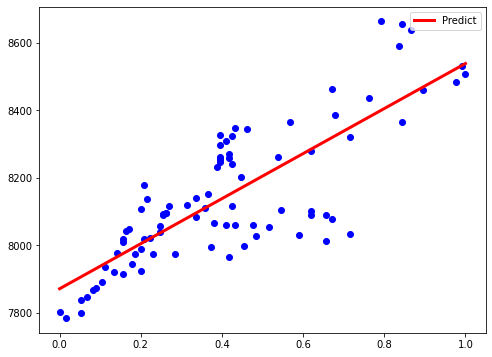

In [44]:
# visualization 하실 분은 진행해주세요!
visualize(model1, train_x1, train_y)

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [45]:
# transform을 하시는 분들은 실행해주세요
test_x = test_x['Temp']

In [46]:
test_x = test_x[:,np.newaxis]
test_x1 = scaler.transform(test_x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


In [47]:
# pred_y에 predict값 할당
pred_y = model1.predict(test_x1)

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [48]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

In [49]:
test_mse = mse(pred_y, test_y)
print(f"Linear {test_mse:.5f}")

Linear 198060.52184


In [50]:
score(train_mse,test_mse)

 13.6182


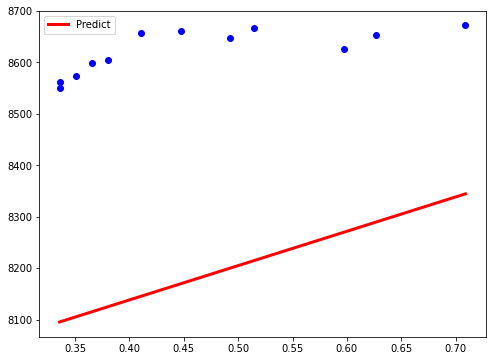

In [51]:
# visualization 하실 분은 진행해주세요!
visualize(model1, test_x1, test_y)

# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

##1. Ridge Regression 활용

In [52]:
# 관련 모듈 import
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

In [53]:
p1 = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)),
                     ('scaler', MinMaxScaler()),
                     ('ridgemodel', Ridge(alpha=0.2))])

In [54]:
# 파이프라인 fitting
p1.fit(train_x, train_y)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', MinMaxScaler()), ('ridgemodel', Ridge(alpha=0.2))])

In [57]:
esti_y2 = p1.predict(train_x)

In [58]:
train_mse2 = mse(esti_y2, train_y)
print(f"Ridge {train_mse2:.5f}")

Ridge 14654.52547


In [59]:
pred_y2 = p1.predict(test_x)

In [60]:
test_mse2 = mse(pred_y2, test_y)
print(f"Ridge {test_mse2:.5f}")

Ridge 202508.11941


In [61]:
score(train_mse2,test_mse2)

 13.8188


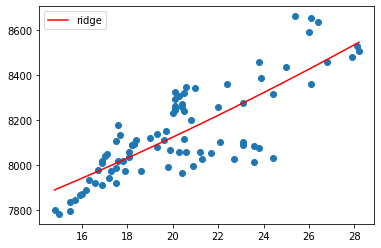

In [56]:
plt.scatter(train_x[:, 0], train_y)
plt.plot(np.sort(train_x[:, 0]), 
         np.sort(p1.predict(train_x)), 
         c='r', label='ridge')
plt.legend();

고생하셨습니다!

##2. StandardScaler 활용

In [62]:
scaler2 = StandardScaler()

In [63]:
train_x2 = scaler2.fit_transform(train_x)
train_x2

array([[-0.80942259],
       [-0.77879955],
       [-0.84004563],
       [-0.96253778],
       [-0.99316082],
       [-1.02378386],
       [-1.08502994],
       [-1.02378386],
       [-0.74817651],
       [-0.28883093],
       [ 0.07864553],
       [ 0.56861415],
       [ 0.87484454],
       [ 0.87484454],
       [ 1.02795973],
       [ 1.08920581],
       [ 1.27294404],
       [ 1.02795973],
       [ 0.75235238],
       [ 0.32362984],
       [-0.13571574],
       [-0.5031922 ],
       [-0.71755347],
       [-0.93191475],
       [-1.11565298],
       [-1.23814513],
       [-1.33001425],
       [-1.39126033],
       [-1.4525064 ],
       [-1.66686767],
       [-1.6056216 ],
       [-1.4525064 ],
       [-1.29939121],
       [-1.02378386],
       [-0.90129171],
       [-0.84004563],
       [-1.20752209],
       [-0.84004563],
       [ 0.04802249],
       [ 0.20113769],
       [ 0.446122  ],
       [ 0.2930068 ],
       [ 0.10926857],
       [ 0.01739945],
       [-0.1050927 ],
       [-0

In [64]:
model1.fit(train_x2, train_y)

LinearRegression()

In [65]:
esti_y3 = model1.predict(train_x2)

In [66]:
train_mse3 = mse(esti_y3, train_y)
print(f"Linear {train_mse3:.5f}")

Linear 14543.75828


In [67]:
test_x2 = scaler2.transform(test_x)

In [68]:
pred_y3 = model1.predict(test_x2)

In [69]:
test_mse3 = mse(pred_y3, test_y)
print(f"Linear {test_mse3:.5f}")

Linear 198060.52184


mse loss가 매우 크다. train 데이터를 보았을 때 선형적 관계를 띄는 것은 맞아보인다.

추가적으로 x 변수들을 늘려보거나 linear regression이 아닌 다른 regression 모델을 활용해보아야겠다.